### Kayla Hoffman 
### Github Username: kaylah176
### USC ID: 5610 8598 16

### Homework 5 - Decision Trees 

In [48]:
# Import libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import _tree
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz

## 1. Decision Trees as Interpretable Models

#### (a)
### Download the Accute Inamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.

#### (b) 
### Build a decision tree on the whole data set and then plot it. 

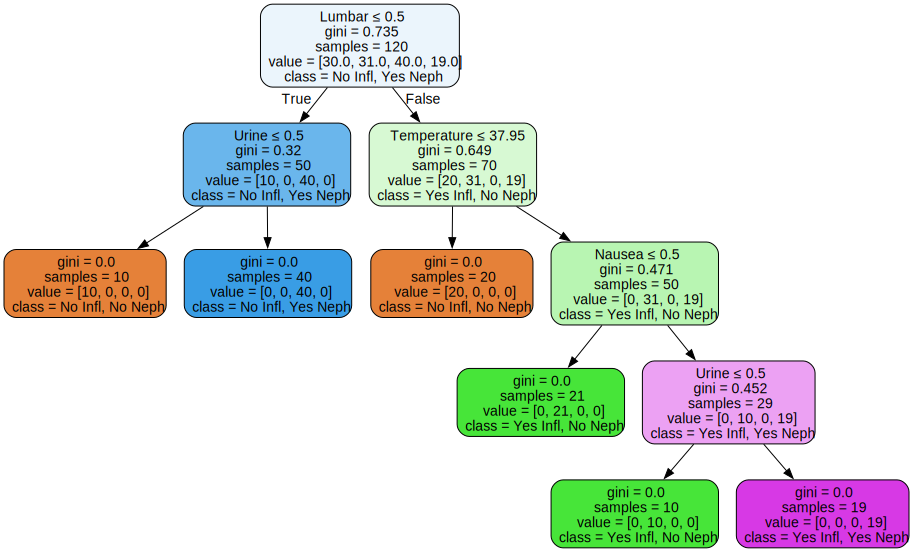

In [49]:
# Load and preprocess the data
diagnosis_header = ["Temperature", "Nausea", "Lumbar", "Urine", "Micturition", "Urethra", "Inflammation", "Nephritis"]
diagnosis = pd.read_csv("diagnosis.data", sep="\t", names=diagnosis_header, encoding='utf-16')

# Convert Temperature to float
diagnosis['Temperature'] = diagnosis['Temperature'].str.replace(',', '.').astype(float)

# Create target variable
diagnosis['Class'] = (diagnosis['Inflammation'].map({'yes': 1, 'no': 0}) * 2 +
                      diagnosis['Nephritis'].map({'yes': 1, 'no': 0}))

# Convert yes/no to 1/0 for feature columns
for col in diagnosis.columns[1:-3]:
    diagnosis[col] = diagnosis[col].map({'yes': 1, 'no': 0})

# Prepare features and target
X = diagnosis.iloc[:, :-3]
y = diagnosis['Class']

# Create and fit the decision tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X, y)

# Visualize the decision tree
dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns,  
                           class_names=['No Infl, No Neph', 'Yes Infl, No Neph', 
                                        'No Infl, Yes Neph', 'Yes Infl, Yes Neph'],
                           filled=True, rounded=True,  
                           special_characters=True)

graph = graphviz.Source(dot_data)
display(graph)


In [50]:
def tree_to_code(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def predict_class({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            class_index = np.argmax(tree_.value[node])
            class_name = class_names[class_index]
            print('{}return "{}"'.format(indent, class_name))

    recurse(0, 1)

# Define class_name before calling tree_to_code
class_name = ["No Inflammation, No Nephritis", "Yes Inflammation, No Nephritis", 
              "No Inflammation, Yes Nephritis", "Yes Inflammation, Yes Nephritis"]

# Now call the function
tree_to_code(dt, list(X.columns), class_name)


def predict_class(Temperature, Nausea, Lumbar, Urine, Micturition, Urethra):
    if Lumbar <= 0.5:
        if Urine <= 0.5:
            return "No Inflammation, No Nephritis"
        else:  # if Urine > 0.5
            return "No Inflammation, Yes Nephritis"
    else:  # if Lumbar > 0.5
        if Temperature <= 37.95000076293945:
            return "No Inflammation, No Nephritis"
        else:  # if Temperature > 37.95000076293945
            if Nausea <= 0.5:
                return "Yes Inflammation, No Nephritis"
            else:  # if Nausea > 0.5
                if Urine <= 0.5:
                    return "Yes Inflammation, No Nephritis"
                else:  # if Urine > 0.5
                    return "Yes Inflammation, Yes Nephritis"


#### (d) Use cost complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,alpha,score,std
0,0.0,0.989474,0.021053
1,0.101626,0.907368,0.094009
2,0.132479,0.749474,0.078603
3,0.182713,0.614737,0.039722
4,0.219187,0.427895,0.123965


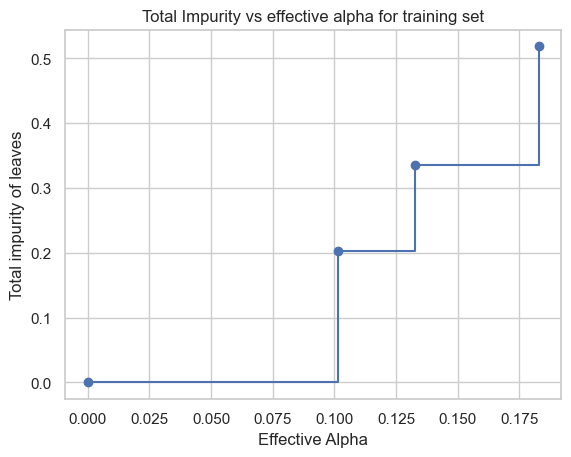

In [51]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Grow a full tree to get potential ccp_alpha values
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities  # Add this line

# Remove last alpha value in the plot becase it is trivial
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("Effective Alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# Step 2: Define the parameter grid for GridSearchCV
param_grid = {'ccp_alpha': ccp_alphas}

# Step 3: Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=param_grid,
    scoring='accuracy',  # Use accuracy as the evaluation metric
    cv=5,                # 5-fold cross-validation
    verbose=1            # Print progress
)

grid_search.fit(X_train, y_train)

gridsearch_alphas = grid_search.cv_results_['param_ccp_alpha']
gridsearch_score = grid_search.cv_results_['mean_test_score']
gridsearch_std = grid_search.cv_results_['std_test_score']

# Record the values of alpha, mean accuracy rate, standard deviation of accuracies
df_result = pd.DataFrame({'alpha': gridsearch_alphas, 'score': gridsearch_score, 'std': gridsearch_std})
df_result = df_result.sort_values(['score'], ascending = False)
display(df_result)

# # Step 4: Get the best alpha value and corresponding model
# optimal_alpha = grid_search.best_params_['ccp_alpha']
# best_model = grid_search.best_estimator_

# print(f"Optimal ccp_alpha: {optimal_alpha}")
# print(f"Best cross-validated accuracy: {grid_search.best_score_}")

# # Step 5: Evaluate the pruned tree on the test set
# test_accuracy = best_model.score(X_test, y_test)
# print(f"Test accuracy of pruned tree: {test_accuracy}")


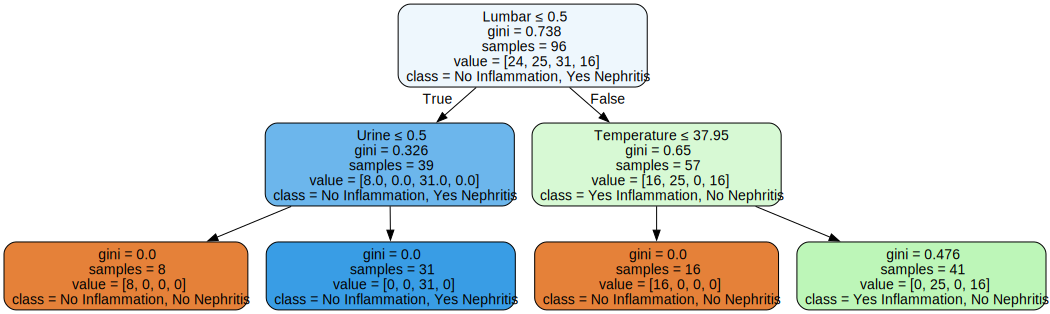

In [52]:
# Fit new model with pruned parameters
clf_minimal = tree.DecisionTreeClassifier(ccp_alpha=df_result.iloc[1,0])
clf_minimal = clf_minimal.fit(X_train, y_train)

# Visualize the decision tree
dot_data = export_graphviz(clf_minimal, out_file=None, 
                           feature_names=X.columns,  
                           class_names=class_name,
                           filled=True, rounded=True,  
                           special_characters=True)

del graph
graph = graphviz.Source(dot_data)

graph

In [53]:
# Display decision path for minimal decision tree
tree_to_code(clf_minimal, list(X.columns), class_name)

def predict_class(Temperature, Nausea, Lumbar, Urine, Micturition, Urethra):
    if Lumbar <= 0.5:
        if Urine <= 0.5:
            return "No Inflammation, No Nephritis"
        else:  # if Urine > 0.5
            return "No Inflammation, Yes Nephritis"
    else:  # if Lumbar > 0.5
        if Temperature <= 37.95000076293945:
            return "No Inflammation, No Nephritis"
        else:  # if Temperature > 37.95000076293945
            return "Yes Inflammation, No Nephritis"


The minimal decision tree plot and decision path are displayed above. The tree has been pruned where there are fewer branches, and the set of IF-THEN rules has been shorten compared to what we have for the original decision tree. 

### 2. The LASSO and Boosting for Regression

### (a)

In [54]:
# Read communities data 
communities = pd.read_csv("communities.data", header=None)
display(communities)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


### (b)

In [55]:
# Remove the first 5 columns that are non-predictive according to the homework description
communities.drop([0, 1, 2, 3, 4], axis=1, inplace=True)

# Replace ? value to np.nan
communities = communities.replace('?', np.nan)
# Use simpleimputer for the missing values
imp = SimpleImputer(strategy="mean")
communities_imp = imp.fit_transform(communities)
# Convert result to dataframe
communities_imp = pd.DataFrame(communities_imp)
display(communities_imp)

,0,1,2,3,4,5,6,7,8,9,...,113,114,115,116,117,118,119,120,121,122
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


### (c) Plot a correlation matrix for the features in the data set.

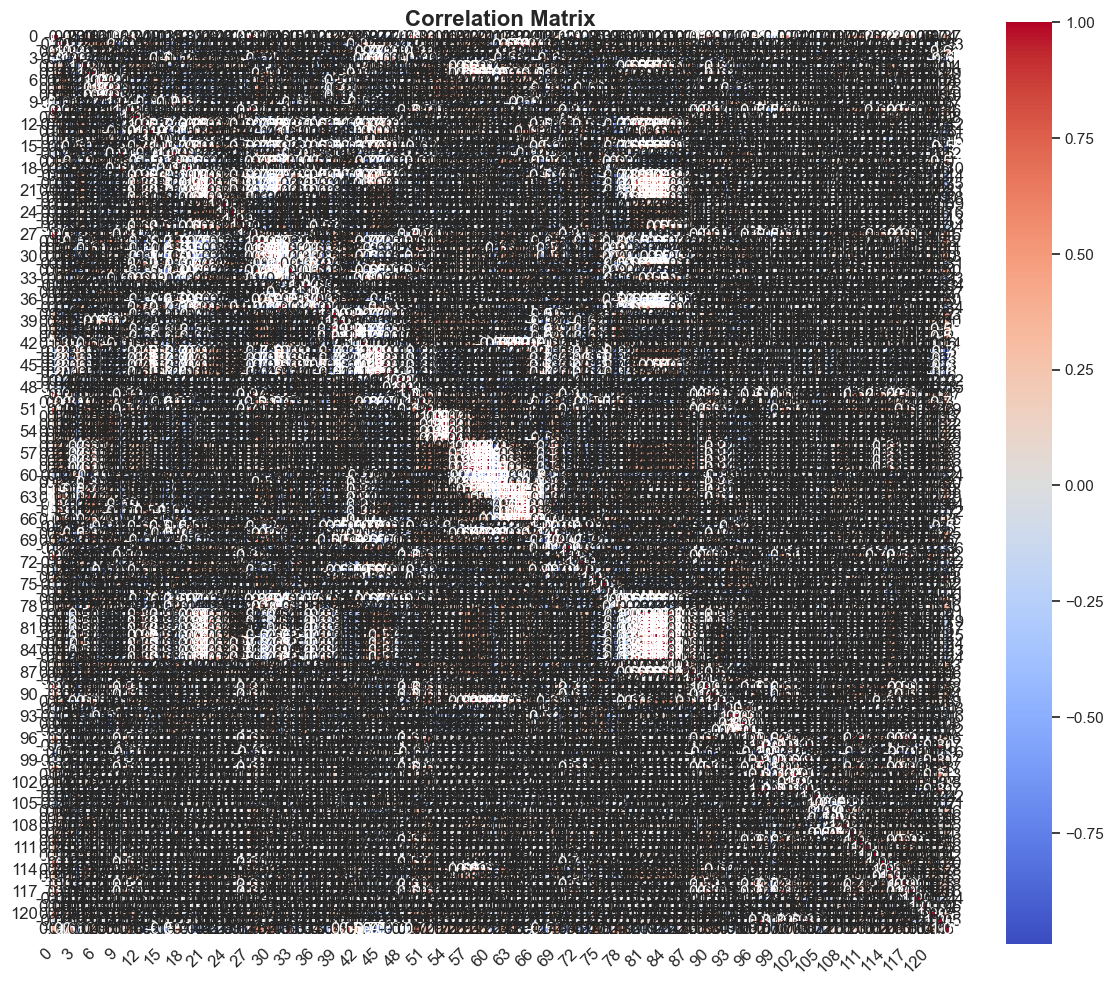

In [56]:
# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    communities_imp.corr(),  # Correlation matrix
    annot=True,             # Display correlation values in each cell
    fmt=".2f",              # Format correlation values to 2 decimal places
    cmap="coolwarm",        # Use a diverging colormap for better visual contrast
    cbar=True,              # Show the color bar
    square=True,            # Ensure cells are square-shaped
    linewidths=0.5,         # Add lines between cells for clarity
    linecolor="white"       # Set line color between cells
)
plt.title("Correlation Matrix", fontsize=16, fontweight="bold")  # Enhanced title formatting
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)  # Adjust y-axis label font size
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


### (d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m, in which s is sample standard deviation and m is sample mean

In [57]:
# Define function to calculate cv
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
# Apply to dataframe and store result
communities_cv = pd.DataFrame(communities_imp.apply(cv), columns=['CV'])
display(communities_cv)

,CV
0,220.350254
1,35.329830
2,141.092040
3,32.378156
4,135.916219
...,...
118,12.233126
119,36.804007
120,255.526600
121,33.728080


### (e) Pick $\sqrt{128}$ features with highest CV and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [14]:
# Sort the dataframe and obtain top CV indexes
communities_top_cv = communities_cv.sort_values(by=['CV'], ascending=False).head(math.floor(math.sqrt(128)))
top_index = communities_top_cv.index.to_list()

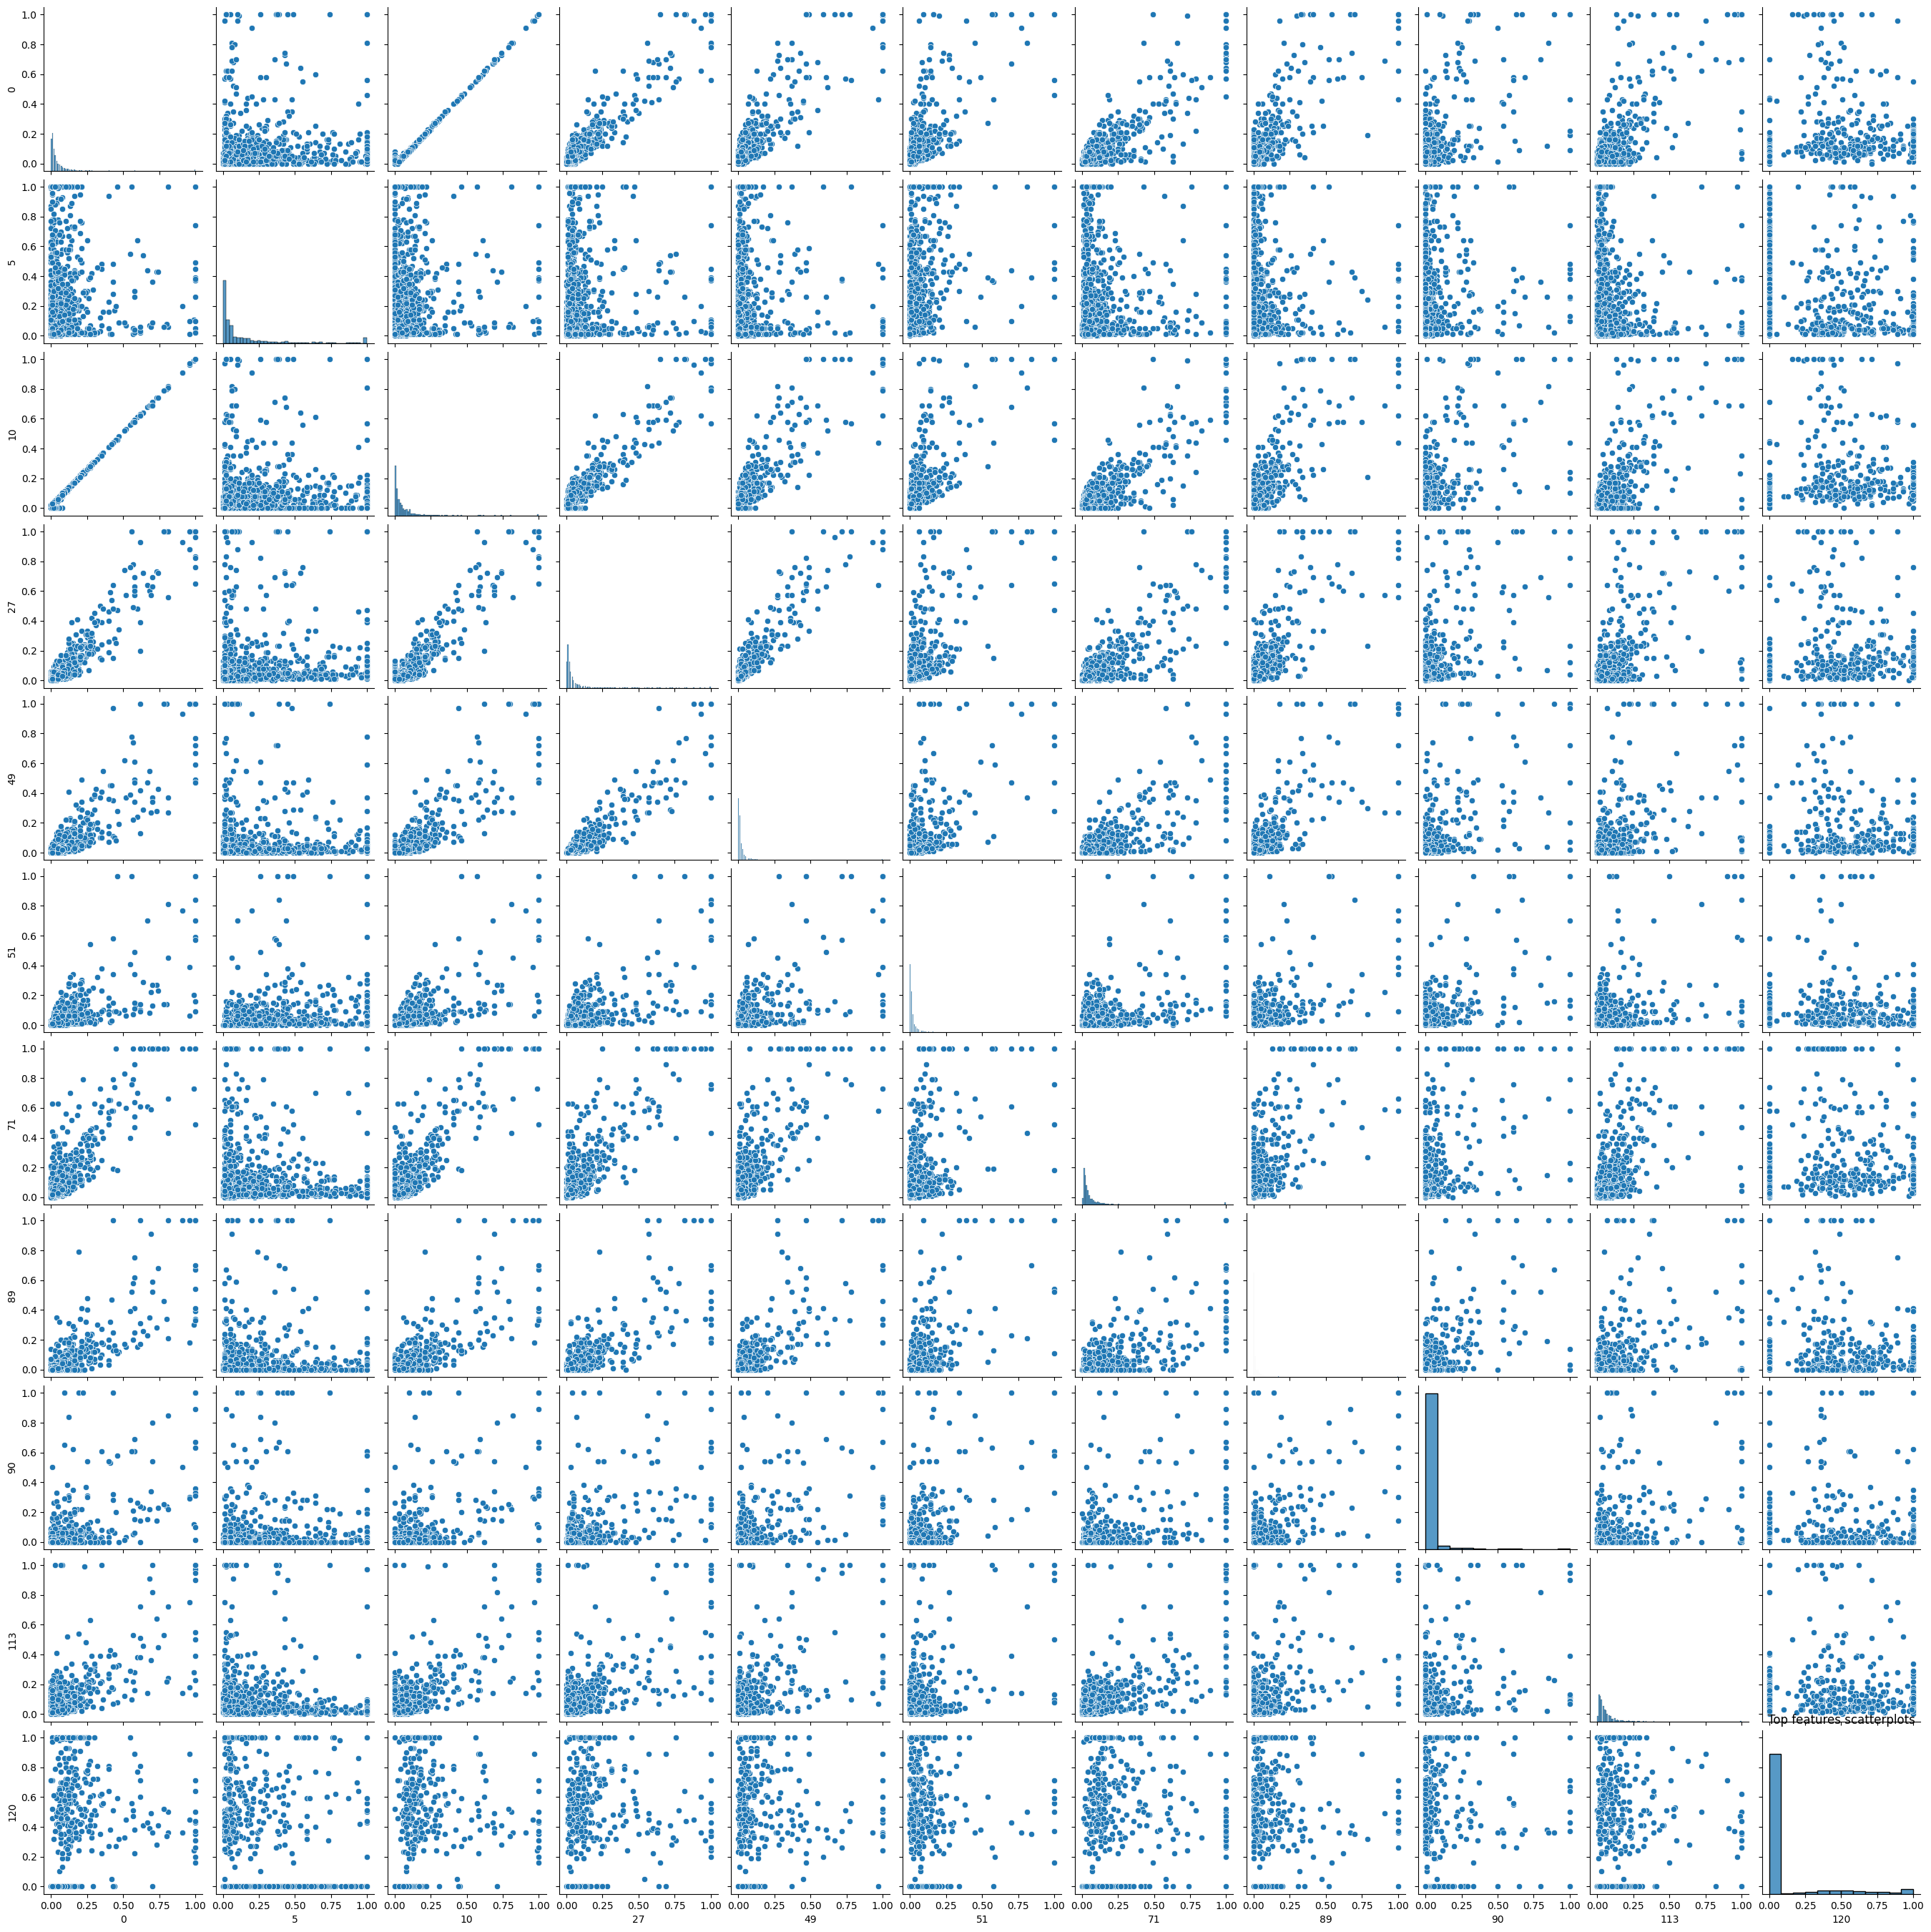

In [15]:
# Make scatter plots for top CV features
communities_cv_features = communities_imp[communities_imp.columns.intersection(top_index)]
sns.pairplot(communities_cv_features)
plt.title("Top features scatterplots")
plt.show()

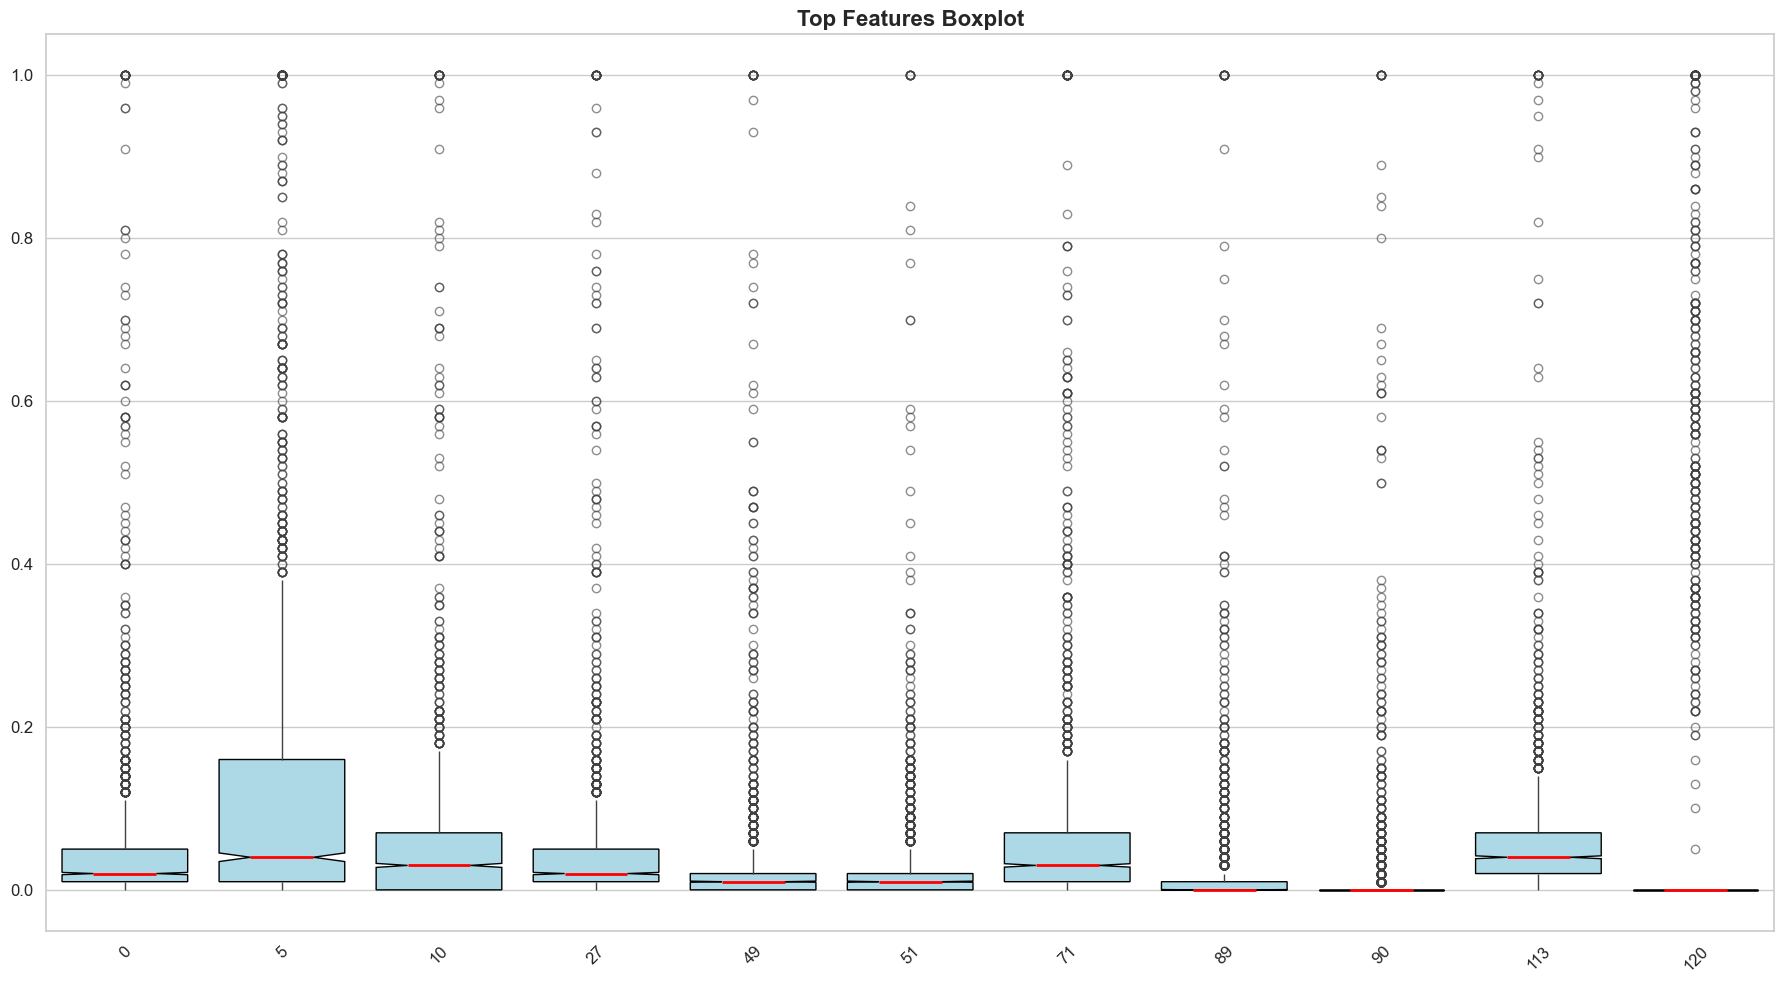

In [16]:
# Set a theme for better aesthetics
sns.set_theme(style="whitegrid")

# Create the boxplot with customizations
plt.figure(figsize=(18, 10))  # Adjust figure size for better visibility
sns.boxplot(
    data=communities_cv_features,
    notch=True,  # Add notches to emphasize medians
    showcaps=False,  # Hide caps for cleaner appearance
    boxprops={"facecolor": "lightblue", "edgecolor": "black"},  # Customize box color and edges
    medianprops={"color": "red", "linewidth": 2},  # Highlight median line
    flierprops={"marker": "o", "color": "darkorange", "alpha": 0.6},  # Customize outliers
)
plt.title("Top Features Boxplot", fontsize=16, fontweight="bold")  # Enhance title formatting
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for readability
plt.yticks(fontsize=12)  # Adjust y-axis label font size
plt.tight_layout()  # Prevent overlap of elements
plt.show()


We can determine that there is a relationships between certain features due to the strongly identifiable linear relationships in box (0, 10). In addition, within other plots, there are a large amount of values concentrated to one point. However, this might not be enough to draw a strong conclusion, just a introductory understanding of our features.

### (f) Fit a linear model using least squares to the training set and report the test error. 

In [17]:
# Use first 1495 rows of data as the training set and the rest as the test set
communities_train = communities_imp.iloc[:1495, :]
communities_test = communities_imp.iloc[1495:, :]
display(communities_train.shape)
display(communities_test.shape)

# Obtain explanatory variable & response variable
X_train = communities_train.iloc[:, :-1]
y_train = communities_train.iloc[:, -1:]
X_test = communities_test.iloc[:, :-1]
y_test = communities_test.iloc[:, -1:]

# 3. Train the Linear Regression Model
model = LinearRegression()  # Create a linear regression object
model.fit(X_train, y_train)  # Fit the model to the training data

# 4. Make Predictions on the Test Set
y_pred = model.predict(X_test)  # Predict on the test set

# 5. Evaluate the Model
# Calculate Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)

# Print the test error
print(f"Mean Squared Error on the Test Set: {mse}")

(1495, 123)

(499, 123)

Mean Squared Error on the Test Set: 0.7897255274121842


### (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained. 

In [37]:
# Generate lambdas
lambdas = [10**i for i in range(-4, 5)]
print(lambdas)

# Ridge regression model
ridge_reg = RidgeCV(alphas=lambdas, cv=5).fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)
# Report MSE
ridge_reg_MSE = mean_squared_error(y_test, y_pred)
print("MSE:", ridge_reg_MSE)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
MSE: 0.01773708110430371


### (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them. 


#### Lasso Model with Cross Validation (Unstandardized)

In [32]:
# 1. Lasso Model with Cross-Validation (Unstandardized)
# -----------------------------------------------------

# a. Define a range of lambdas (adjusted for unstandardized data)
alphas = np.logspace(-4, 2, 100)  # Test alphas from 1e-4 to 1e2

# b. Perform cross-validation to find the best alpha
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_values = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)  # Increased max_iter for convergence
    
    # Catch warnings related to convergence issues
    with warnings.catch_warnings():
        warnings.simplefilter("error", category=ConvergenceWarning)
        try:
            scores = cross_val_score(lasso, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
            mse_values.append(-np.mean(scores))
        except ConvergenceWarning:
            print(f"Alpha {alpha:.2e} failed to converge - skipping")
            mse_values.append(np.inf)

# Filter out invalid MSE values and select best alpha
valid_mse_values = [mse for mse in mse_values if mse != np.inf]
if len(valid_mse_values) == 0:
    raise ValueError("No valid alphas found! Check feature scaling or increase max_iter.")

best_alpha = alphas[np.argmin(valid_mse_values)]

# c. Fit the Lasso model with the best alpha and check convergence
lasso = Lasso(alpha=best_alpha, max_iter=10000)
lasso.fit(X_train, y_train)

if lasso.n_iter_ == 10000:
    print(f"Warning: Final model with alpha={best_alpha:.2e} did not converge!")

# d. Evaluate and report MSE on test set
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\nLASSO (Unstandardized) Results:")
print(f"- Test MSE: {mse:.4f}")
print(f"- Best Alpha (λ): {best_alpha:.4e}")

# e. Report selected variables (non-zero coefficients)
importance = np.abs(lasso.coef_)  # Get absolute coefficient values

selected_features = list(X_train.columns[importance > 0])  # Features with non-zero coefficients
print(f"- Selected Features ({len(selected_features)}): {selected_features}")
print(f"- Total Number of Selected Variables: {len(selected_features)}")



LASSO (Unstandardized) Results:
- Test MSE: 0.0178
- Best Alpha (λ): 1.1498e-04
- Selected Features (75): [2, 4, 6, 7, 11, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 28, 29, 33, 34, 36, 38, 39, 40, 44, 45, 46, 48, 49, 50, 51, 55, 59, 61, 63, 64, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 82, 85, 86, 87, 88, 89, 90, 91, 92, 94, 99, 100, 102, 104, 106, 108, 110, 111, 112, 113, 114, 115, 118, 119, 120, 121]
- Total Number of Selected Variables: 75


In [33]:
# Report MSE
lasso_reg_MSE = mean_squared_error(y_test, y_pred)
print("LASSO (Unstandardized) - MSE:", lasso_reg_MSE)
print("LASSO (Unstandardized) - Best Alpha:", lasso_reg.alpha_)  # Get the best alpha

# Report selected variables
importance = np.abs(lasso_reg.coef_)  # Get absolute coefficient values
selected_features = list(X_train.columns[importance > 0])  # Features with coef > 0
print("LASSO (Unstandardized) - Selected Features:", selected_features)
print("LASSO (Unstandardized) - Total number of selected variables:", len(selected_features))

# 3. LASSO Model (Standardized) with LassoCV
# a. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# b. Define a range of alphas (log-spaced, suitable for standardized features)
lambdas_scaled = np.logspace(-4, 1, 100)  # Smaller values work better after scaling

# c. Fit LASSO with cross-validation using scaled data
lasso_reg_scaled = LassoCV(alphas=lambdas_scaled, cv=5, random_state=42, max_iter=10000)
lasso_reg_scaled.fit(X_train_scaled, y_train)

# d. Predictions on scaled test set
y_pred_scaled = lasso_reg_scaled.predict(X_test_scaled)

# e. Report MSE
lasso_reg_scaled_MSE = mean_squared_error(y_test, y_pred_scaled)
print("\nLASSO (Standardized) Results:")
print(f"- Test MSE: {lasso_reg_scaled_MSE:.4f}")
print(f"- Best Alpha (λ): {lasso_reg_scaled.alpha_:.4e}")

# f. Report selected variables (scaled data)
importance_scaled = np.abs(lasso_reg_scaled.coef_)  # Get absolute coefficient values

# Unscale coefficients for interpretability
coef_unscaled = lasso_reg_scaled.coef_ / scaler.scale_  # Adjust coefficients back to original scale

selected_features_scaled = list(X_train.columns[coef_unscaled != 0])  # Features with non-zero coefficients
print(f"- Selected Features ({len(selected_features_scaled)}): {selected_features_scaled}")
print(f"- Total Number of Selected Variables: {len(selected_features_scaled)}")

LASSO (Unstandardized) - MSE: 0.01776646564769414
LASSO (Unstandardized) - Best Alpha: 0.00011497569953977356
LASSO (Unstandardized) - Selected Features: [2, 4, 6, 7, 11, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 28, 29, 33, 34, 36, 38, 39, 40, 44, 45, 46, 48, 49, 50, 51, 55, 59, 61, 63, 64, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 82, 85, 86, 87, 88, 89, 90, 91, 92, 94, 99, 100, 102, 104, 106, 108, 110, 111, 112, 113, 114, 115, 118, 119, 120, 121]
LASSO (Unstandardized) - Total number of selected variables: 75

LASSO (Standardized) Results:
- Test MSE: 0.0178
- Best Alpha (λ): 8.1113e-04
- Selected Features (73): [2, 4, 6, 7, 11, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 28, 29, 33, 34, 38, 39, 40, 44, 45, 46, 48, 49, 50, 51, 53, 55, 59, 61, 63, 64, 67, 68, 69, 71, 72, 74, 75, 76, 77, 78, 82, 85, 86, 87, 88, 89, 90, 91, 94, 99, 100, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 118, 119]
- Total Number of Selected Variables: 73


### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross validation. Report the test error obtained. 

Number of components corresponding to the smallest MSE: 95


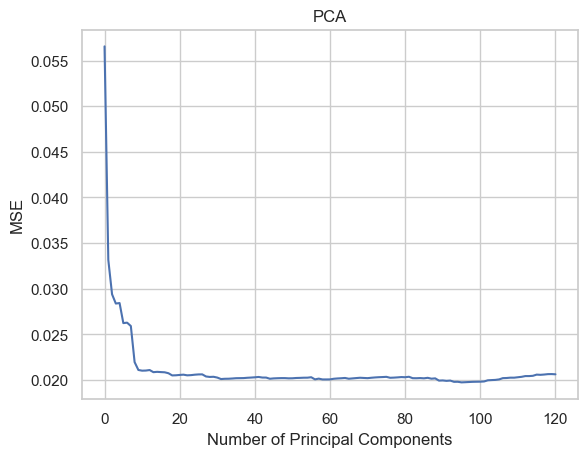

In [45]:
# 2. Apply PCA
pca = PCA()
X_reduced = pca.fit_transform(preprocessing.scale(X_train))

# 3. Define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=24)
regr = LinearRegression()
mse = []

# 4. Calculate MSE with only the intercept
score = -1*cross_val_score(regr, np.ones((len(X_reduced),1)), y_train, cv=cv, scoring='neg_mean_squared_error').mean()
mse.append(score)

# 5. Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 121):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

# 6. Convert MSE to a NumPy array
mse = np.array(mse)

# 7. Find the index of the minimum MSE value
min_index = np.argmin(mse)

# 8. Print the results
print("Number of components corresponding to the smallest MSE:", min_index)

# 9. Plot results
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('PCA')
plt.show()


In [41]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 21.21,  35.39,  44.18,  51.08,  56.83,  60.81,  64.17,  67.26,
        69.81,  71.86,  73.56,  75.03,  76.44,  77.78,  79.02,  80.12,
        81.18,  82.09,  82.95,  83.8 ,  84.6 ,  85.35,  86.08,  86.79,
        87.47,  88.1 ,  88.7 ,  89.27,  89.8 ,  90.28,  90.76,  91.22,
        91.65,  92.06,  92.46,  92.84,  93.2 ,  93.55,  93.88,  94.2 ,
        94.51,  94.8 ,  95.08,  95.33,  95.57,  95.81,  96.02,  96.23,
        96.43,  96.61,  96.79,  96.96,  97.12,  97.28,  97.43,  97.57,
        97.7 ,  97.83,  97.96,  98.07,  98.18,  98.29,  98.39,  98.48,
        98.57,  98.65,  98.73,  98.81,  98.88,  98.95,  99.01,  99.07,
        99.13,  99.18,  99.23,  99.28,  99.33,  99.37,  99.41,  99.45,
        99.49,  99.53,  99.56,  99.59,  99.62,  99.65,  99.68,  99.71,
        99.74,  99.76,  99.78,  99.8 ,  99.82,  99.84,  99.86,  99.88,
        99.89,  99.9 ,  99.91,  99.92,  99.93,  99.94,  99.95,  99.96,
        99.97,  99.98,  99.99, 100.  , 100.  , 100.  , 100.  , 100.  ,
      

From the PCA plot and the printed array above, we can see that MSE decreases rapidly when the number of principal components is growing from 0 to 15. We see the MSE gradually decrease when the number of principal components grows. The smallest MSE found was at the 95th principal component. However, combing the result of explained variance ratio, we can see that including more principal components does not help much. Therefore, let's pick the number of principal components at 20. 

In [42]:
pca = PCA(n_components=20)
X_reduced_train = pca.fit_transform(preprocessing.scale(X_train))
X_reduced_test = pca.transform(preprocessing.scale(X_test))

# Train PCR model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train, y_train)

# calculate MSE
pred = regr.predict(X_reduced_test)
PCA_mse = mean_squared_error(y_test, pred)
print("MSE:", PCA_mse)

MSE: 0.017819984777795783


### (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine (the regularization term) using cross-validation.

In [46]:
# Declare a list of alpha values
alphas = list(np.logspace(1e-4, 2, 20))

In [47]:
# Declare XGBRegressor model
xgbtree = xgb.XGBRegressor(verbosity=0)
# Define GridSearchCV parameters
param_grids = {'reg_alpha': alphas, 'random_state':[42]}
gridSearch = GridSearchCV(xgbtree, param_grid=param_grids, cv=5, scoring='neg_mean_squared_error')
gridSearch.fit(X_train, y_train)

gridSearch_alphas = gridSearch.cv_results_['param_reg_alpha']
gridSearch_score = -gridSearch.cv_results_['mean_test_score']
gridSearch_std = gridSearch.cv_results_['std_test_score']

# Record the values of alpha, mean accuracy rate, standard deviation of accuracies
df_result = pd.DataFrame({'alpha': gridSearch_alphas, 'mse': gridSearch_score, 'std': gridSearch_std})
df_result = df_result.sort_values(['mse'], ascending = True)
display(df_result.head(10))

,alpha,mse,std
6,4.282007,0.021228,0.002675
8,6.952855,0.021229,0.002652
5,3.360388,0.021410,0.002569
3,2.069539,0.021459,0.002335
4,2.63713,0.021503,0.002676
7,5.456388,0.021572,0.003008
0,1.00023,0.021596,0.003112
2,1.624111,0.021803,0.002922
1,1.274553,0.021904,0.002609
9,8.859742,0.022246,0.002796


We can see that at α = 4.282007 we obtain the lowest test MSE under cross validation. 

#### References 
Decision Trees - https://scikit-learn.org/stable/modules/tree.html 
Imputation of missing values - https://scikit-learn.org/stable/modules/impute.html

Post pruning decision trees with cost complexity pruning - https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://xgboost.readthedocs.io/en/stable/parameter.html